# Assignment 3

## The dataset
For this last assignment I have investigated many different datasets from the UCI, Kaggle and other sources.

Most of the datasets analysed do not have enough instances or do not contain enough information about the features to a level which good explanations can be provided.

The chosen dataset - provided by Kaggle - is a dataset for loans. The features are either self-explanatory or they have good descriptions. It has also a good number of instances and a small imbalance. The link for the dataset follows: 

https://www.kaggle.com/yasserh/loan-default-dataset

## The method

I follow the steps used on many codebooks during the course of XAI. The steps are:

>- Install and import required libraries
>- Load and verify the dataset for NaNs and address them
>- Verify and correct features' datatype, if required
>- Adjust the dataset for the model
>- Create and train the model
>- Verify model performance against the test dataset
>- Analyse the robustness of the mode using multiple XAI techniques (PDP, ICE, LIME, Conterfactuals and inTrees)
>- Final conclusions
>- Appendix

Author: Marcelo Romaniuc
PG Student 2139172

Date: 06.mar.2022

#Install and import required libraries



In [ ]:
! pip install lime
! pip install lightgbm==3.3.2 # required to avoid NotFittedError: This LGBMClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
! pip install alibi==0.6.2 tensorflow-addons h5py imbalanced-learn shap geopandas folium mapclassify
! git clone https://github.com/sato9hara/defragTrees.git

     |████████████████████████████████| 275 kB 13.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=2da643ebfb955223a9fc5bb22070f4713bdffd6a67fd3d3b3fd95ef7f2896a46
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
     |████████████████████████████████| 2.0 MB 15.4 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 390 kB 10.5 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 
     |████████████████████████████████| 564 kB 44.2 MB/s 
     |████████████████████████████████| 1.0 MB 62.5 MB/s 
     |████████████████████████████████| 463.8 MB 35 kB/s 
     |████████████████████████████████| 3.8 MB 80.3 MB/s 
     |████████████████████████████████| 28.0 MB 1.3 MB/s 
     |████████████████████████████████

Cloning into 'defragTrees'...
remote: Enumerating objects: 2491, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2491 (delta 0), reused 0 (delta 0), pack-reused 2488
Receiving objects: 100% (2491/2491), 35.57 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (2158/2158), done.


The next cell imports all relevant classes and algorithms used in the codebook

In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import lightgbm as lgb
#from xgboost import plot_importance

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, plot_confusion_matrix

from sklearn.inspection import PartialDependenceDisplay
#from pdpbox import pdp, info_plots
import shap
import lime
import lime.lime_tabular
from alibi.explainers import CounterfactualProto


from defragTrees.defragTrees import DefragModel

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


# Load and verify the dataset for NaNs and address them

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the dataset and displaying general info about the data

In [ ]:
df = pd.read_csv("./drive/My Drive/XAI-Worksheets/loan/Loan_Default.csv", sep=",", header=0, index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148670 entries, 24890 to 173559
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       148670 non-null  int64  
 1   loan_limit                 145326 non-null  object 
 2   Gender                     148670 non-null  object 
 3   approv_in_adv              147762 non-null  object 
 4   loan_type                  148670 non-null  object 
 5   loan_purpose               148536 non-null  object 
 6   Credit_Worthiness          148670 non-null  object 
 7   open_credit                148670 non-null  object 
 8   business_or_commercial     148670 non-null  object 
 9   loan_amount                148670 non-null  int64  
 10  rate_of_interest           112231 non-null  float64
 11  Interest_rate_spread       112031 non-null  float64
 12  Upfront_charges            109028 non-null  float64
 13  term                     

The cell above shows columns and respective non-nulls. Features with high number of NaNs will be dropped by the next cell. 

In [ ]:
df[df['Status']==1]
#~36.6K
df.drop(columns=['rate_of_interest', 'Interest_rate_spread','Upfront_charges', 'dtir1', 'property_value'], inplace=True)

Based on domain knowledge, the next features, due to their importance to the model, cannot be dropped.

On these features I use statistical estimators to fill the NaNs.

In [ ]:
df['LTV'].fillna(df['LTV'].mean(), inplace=True)
df['income'].fillna(df['income'].min(), inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148670 entries, 24890 to 173559
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       148670 non-null  int64  
 1   loan_limit                 145326 non-null  object 
 2   Gender                     148670 non-null  object 
 3   approv_in_adv              147762 non-null  object 
 4   loan_type                  148670 non-null  object 
 5   loan_purpose               148536 non-null  object 
 6   Credit_Worthiness          148670 non-null  object 
 7   open_credit                148670 non-null  object 
 8   business_or_commercial     148670 non-null  object 
 9   loan_amount                148670 non-null  int64  
 10  term                       148629 non-null  float64
 11  Neg_ammortization          148549 non-null  object 
 12  interest_only              148670 non-null  object 
 13  lump_sum_payment         

Finally, the remaining instances with NaNs will be dropped.

In [ ]:
df = df.dropna()
df.shape

(143942, 28)

# Verify and correct features' datatype, if required

Here I address the categorical versus numerical features



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143942 entries, 24890 to 173559
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       143942 non-null  int64  
 1   loan_limit                 143942 non-null  object 
 2   Gender                     143942 non-null  object 
 3   approv_in_adv              143942 non-null  object 
 4   loan_type                  143942 non-null  object 
 5   loan_purpose               143942 non-null  object 
 6   Credit_Worthiness          143942 non-null  object 
 7   open_credit                143942 non-null  object 
 8   business_or_commercial     143942 non-null  object 
 9   loan_amount                143942 non-null  int64  
 10  term                       143942 non-null  float64
 11  Neg_ammortization          143942 non-null  object 
 12  interest_only              143942 non-null  object 
 13  lump_sum_payment         

In [ ]:
numerical_features=['year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 
                  'Upfront_charges', 'property_value', 'income', 'Credit_Score','LTV', 
                  'dtir1'
                  ]
categorical_features=['loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'credit_type', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'Region', 'Security_Type',
       ]

In [ ]:
col_label='Status'
labels = df[col_label]
df.drop(columns=[col_label], inplace=True)

Checking and adjusting Datatypes

In [ ]:
for feat in df.columns:
  #print(f'Feature: {col}')
  if feat in categorical_features:
    df[feat] = df[feat].astype("category")
  if feat in numerical_features:
    if ( (df[feat].astype("float64") != df[feat].astype("int64")).any()):
      df[feat] = df[feat].astype("float64")
    else:
      df[feat] = df[feat].astype("int64")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143942 entries, 24890 to 173559
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   year                       143942 non-null  int64   
 1   loan_limit                 143942 non-null  category
 2   Gender                     143942 non-null  category
 3   approv_in_adv              143942 non-null  category
 4   loan_type                  143942 non-null  category
 5   loan_purpose               143942 non-null  category
 6   Credit_Worthiness          143942 non-null  category
 7   open_credit                143942 non-null  category
 8   business_or_commercial     143942 non-null  category
 9   loan_amount                143942 non-null  int64   
 10  term                       143942 non-null  category
 11  Neg_ammortization          143942 non-null  category
 12  interest_only              143942 non-null  category
 13  lump_sum_p

# Adjust the dataset for the model

Here I transform the dataset so that it has the right format to be used by the model. Encodings are done if required. Train and test datasets are created.

In [ ]:
#df_enc contains the encoded version of df
#The np_categorical_names is to be used by LIME to reverse the encoding while displaying the explanations
df_enc = df.copy()

np_categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(df[feature])
    df_enc[feature] = le.transform(df_enc[feature])
    np_categorical_names[df.columns.get_loc(feature)] = le.classes_

In [ ]:
categorical_feature_pos = [df_enc.columns.get_loc(x) for x in categorical_features]

In [ ]:
np_df_enc = df_enc.to_numpy().astype(np.float32, copy=False)

X_train, X_test, y_train, y_test = train_test_split(np_df_enc, labels, test_size=0.2, random_state=42)

A final check on the dataset to make sure the dataset has not substantial imbalance

In [ ]:
def show_balance(y):
  print(f"Default (%): {sum(y==1) / y.shape[0]}")
  print(f"No Default (%): {sum(y==0) / y.shape[0]}")
show_balance(y_train)

Default (%): 0.24370185752867923
No Default (%): 0.7562981424713208


# Create and train the model

On this assigment I use Light Gradient Boosted Machine (LGBM).

I do not engage on extensive model performance optimisation here, and rather focus more on the XAI techniques to explain the model behaviour.

In [ ]:
# params dictionary hold arbitrary hyperparameter values. 
# We are not aiming here for any brilliant results - simply trying the model out first!
params = {'max_depth': 6, 
          'min_child_weight': 0, 
          'learning_rate': '0.5', 
          'colsample_bytree': '0.75', 
          'subsample': 1, 
          'reg_lambda': 1,
          'n_estimators': 150,
          'objective': 'binary',
          'random_state':55}

# We are fitting the model on the training set and controlling for overfitting with early stopping.
lgb_model = lgb.LGBMClassifier(**params)

lgb_fitted = lgb_model.fit(X_train, y_train, eval_set=(X_test, y_test), categorical_feature= np_categorical_names, feature_name=df_enc.columns.to_list(), verbose = False, early_stopping_rounds = 500)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


# Verify model performance against the test dataset

A short analysis of model performance, based on the Confusion Matrix and Classification Report is provided at the end of this session. The analysis is based on the test dataset. 

Confusion matrix:


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


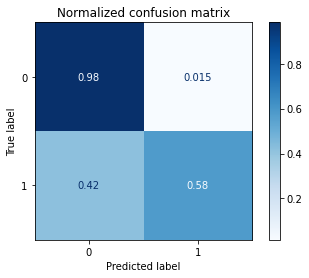

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     21597
           1       0.93      0.58      0.71      7192

    accuracy                           0.88     28789
   macro avg       0.90      0.78      0.82     28789
weighted avg       0.89      0.88      0.87     28789



Done!


In [ ]:
def model_assessment(model, X, y):

    # Get the confusion matrix.
    print("Confusion matrix:")
    disp = plot_confusion_matrix(model, X, y,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    
    disp.ax_.set_title("Normalized confusion matrix")

    plt.show()

    # Produce a classification report.
    print("Classification Report:")
    pred = model.predict(X)
    print(classification_report(y, pred))
    print('\n')  
    print("Done!")

model_assessment(lgb_fitted, X_test, y_test)

The model has an excellent recall for non-default (0.98). This means the model is optimized to find all non-default clients. Considering such high recall for 0 (non-default), I can conclude the model is fit towards maximizing the opportunities for the bank to identify potential clients.

On the other hand, the relative low recall for default (0.58) shows the model is not fit to identify a substantial portion of default clients. The consequence for the bank is an increase on the risk of clients not being able to pay their loans and defaulting on it.

In general, the two recalls must be tuned according to the bank strategy and the balance between risk of default versus profit on new loan busineses.






AxesSubplot(0.125,0.125;0.775x0.755)


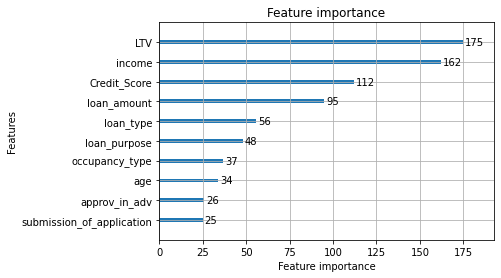

In [ ]:
# Get the underlying booster.
booster = lgb_fitted.booster_

# Produce visualisations.
max_num_feats = 10
print(lgb.plot_importance(booster, max_num_features = max_num_feats, importance_type='split'))

# Analyse the robustness of the mode using multiple XAI techniques (PDP, ICE, LIME, Counterfactuals and inTrees)

For the model explainability session I take a top-down approach, starting from analysing global characteristics of the model and afterwards explaining local specific characteristics for specific clients.  

First, I analyse how the top 10 features influences the model prediction. Moreover, it is important to assess at this point if there is any gender bias in the model. I use ICE and PDP for this analsyis. 

After that, I take some examples of clients with 4 profiles based on probabilities of default (PD): highly non-default (PD=<.20), highly default (PD>=.80), moderated default (0.50<=PD<=0.60) and moderated non-default (0.40<=PD<=0.50). For one client in each profile I display the top features contributing to the decision using LIME.

In addition, using the sets of clients from the profiles above I create counterfactuals. The objective here is to obtain insights on how the model behaves and what needs to be changed for a client to be transitioned from default to non-default or what could cause a non-default client to become a default client.

Finally, the attempt to use inTrees to extract global rules are kept in the appendix of the codebook with the findings when using it.

## Individual Conditional Expectation (ICE) and Partial Dependence Plot (PDP)

I use ICE and PDP plots to analyse the influence of the top 10 features in the model outcome. In addition, 2 plots are added to the analysis to understand if any gender-related bias is present and to check if Region influences the model outcome.

The plots are displayed in a 4x3 matrix, having the most influential feature on the top left. Categorical features are not easily retrofited into the plots, so, the plots show the number associated to a certain category and, for reference, the list of categories for each categorial feature is shown after the plots.

Note the ICE (blue lines) and PDP plot (average, red line) are ploted, for each feature, in the same chart. 

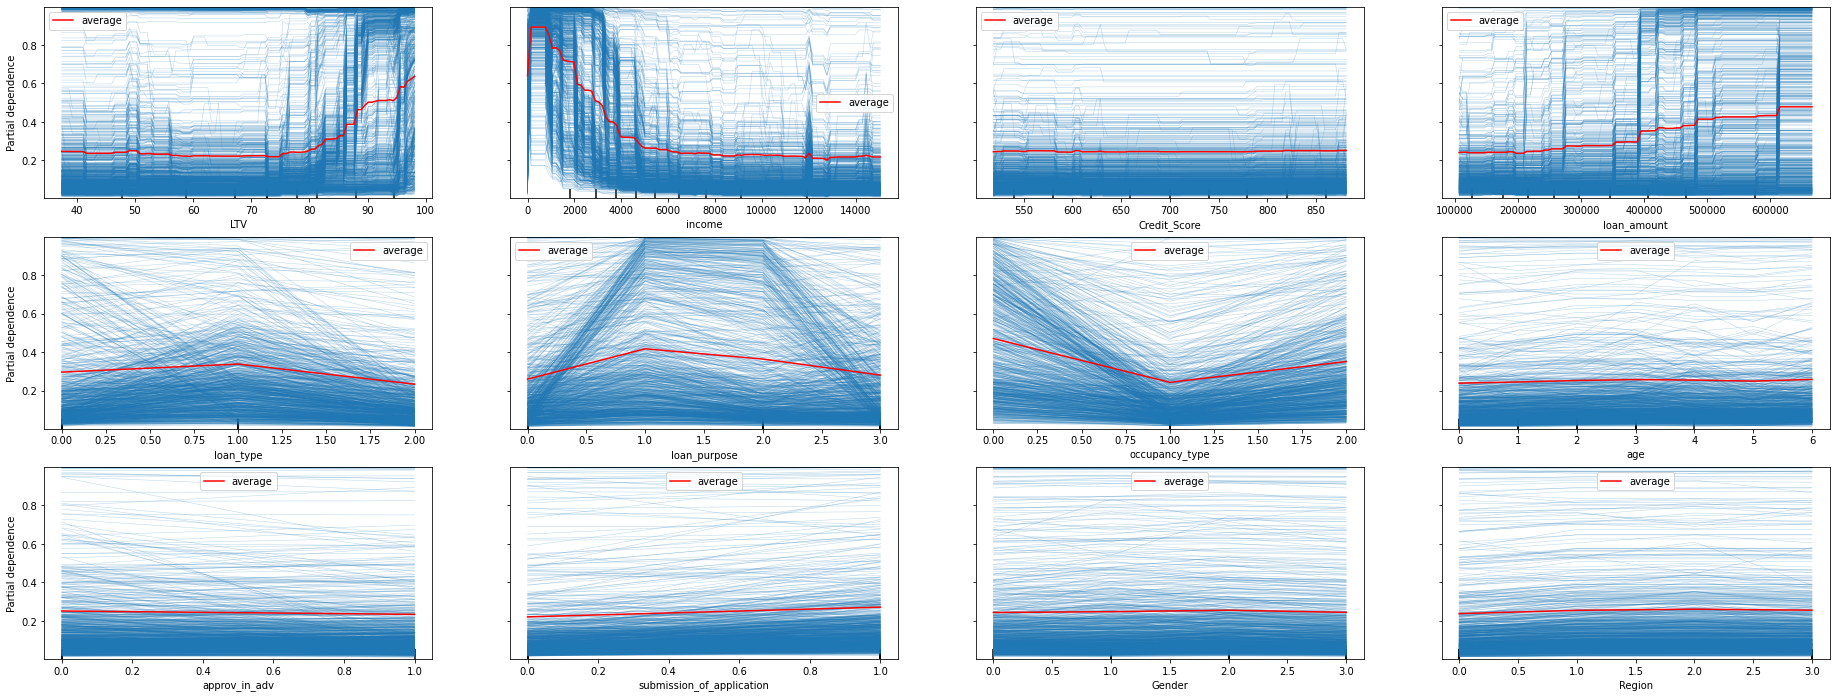

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(32, 12))

feature_map = { x : df_enc.columns.get_loc(x) for x in df_enc.columns}

pdp_feature_names=['LTV', 'income', 'Credit_Score', 'loan_amount', 'loan_type', 'loan_purpose', 'occupancy_type', 'age', 'approv_in_adv', 'submission_of_application', 'Gender', 'Region']
pdp_feature_pos = [ feature_map[name] for name in pdp_feature_names]

PartialDependenceDisplay.from_estimator(lgb_fitted, X_test, features=pdp_feature_pos, feature_names=df_enc.columns, kind='both', ax=ax, pd_line_kw={"color":"red"})

In [ ]:
def feat_classes(feature):
  print(f"{feature} classes: {np_categorical_names[feature_map[feature]]}")

for f in ['loan_type', 'loan_purpose', 'occupancy_type', 'age', 'approv_in_adv', 'submission_of_application', 'Gender', 'Region']:
  feat_classes(f)

loan_type classes: ['type1' 'type2' 'type3']
loan_purpose classes: ['p1' 'p2' 'p3' 'p4']
occupancy_type classes: ['ir' 'pr' 'sr']
age classes: ['25-34' '35-44' '45-54' '55-64' '65-74' '<25' '>74']
approv_in_adv classes: ['nopre' 'pre']
submission_of_application classes: ['not_inst' 'to_inst']
Gender classes: ['Female' 'Joint' 'Male' 'Sex Not Available']
Region classes: ['North' 'North-East' 'central' 'south']


### The LTV Plot
The first plot (top left plot) shows how the LTV (Loan-to-Value) influences in a client default (considering all other features fixed for each instance).

Considering the PDP plot (the red line representing the average), one can observe that the risk of default increases as the loan-to-value increases. Loan to Value is a measure of how much colleral is backing up a loan. Percentages closer to 0 represents that the loan amounts to a tiny fraction of the collateral, therefore, having a very low risk of default. On the other hand, LTVs closer to 1 implies that the loan amount is very close to the collateral amount, presenting more risk of default.

It is sensible to conclude that the model reflects an expected behaviour in loan business. On the plot, LTV values above 0.8 have a substancial higher risk of default. In fact, in some countries, loans which causes LTV above 80% cannot be approved by law.

### The Income Plot
The second plot (on the right to the LTV one) shows how income influences the default.

Here again the model reflects an expected behaviour in business. The relation between income and default, for this dataset, shows that lending to low-income borrowers are riskier than for high income borrowers, or the smaller the income, the higher is the probability of default. Such correlation does not have to be always present, nevertheless, it is also not surprising when the model infers such correlation.

### The Credit Score Plot
The third plot shows how the credit score influences in the default. The line is relatively flat accross all values of credit score, indicating that, in average, there is no significant influence on the default due to the credit score. Here is worth looking at the ICE plot (blue lines). One can observe that, on the left side of the chart (up to value 650) and on the right side (after the value 750) of the plot, there are more variability on the blue lines. Such variability indicates that, in these regions and for some instances of the dataset, the Credit Score has a material influence.

### The Loan Amount Plot
The loan amount plot also shows an expected model's behaviour. The average line shows that, the greater the loan, the riskier is the default. From the lowest to the highest loan value, there is, considering the averge line, about 0.2 change towards default.

### The Loan Type Plot
Here one can see a slight variation on the average/red line. As this is a categorical feature, the values 0, 1, 2 represent respectively 'type1' 'type2' 'type3' loan. There is not much detail about the loan types in the dataset documentation to be able to present a deeper analysis. All I can conclude here is that loans of type3 have a slighly advantage for non-default compared to the other types of loans.

### The Loan Purpose Plot
Here is another categorical feature with possible values being 'p1' 'p2' 'p3' 'p4'. According to the plot, in average, the loan purpose p4 constributes less to the probability of default than the other loan purposes. There is not many details about this feature on the documentation.

### The Occupancy Type Plot
Another categorical feature with possible values being 'ir' 'pr' 'sr'. He borrowers with the occupancy type 'pr' have a slight less probability of devault than borrowers of the other types.  

### The Age, Approved in advance and submission of application Plots
For these 3 plots, the average is relatively flat across all the possible values for the respective features. It is worth noticing the behaviour of the blue lines on the Age plot after the value 4 (65-74). There are some instances where the probability of default increases for such ages, indicating loans for borrowers above 65 years old can be riskier than for younger borrowers. Here more investigations are required to understand if an "age bias" is present in the model.

### The Gender Plot
Here is an important characteristic to check in the model - is there gender bias in the model? The answer is NO. Appart from some small fluctuations in some instances, we can observe that all the instances (and the average) remain fairly flat across all possible values for gender ('Female' 'Joint' 'Male' 'Sex Not Available'). This is a good indication the model is not gender biased.

### The Region Plot
In this plot I can conclude the region does not play a strong influence on the probability of default. The average remains relatively flat across all possible regions.

### Conclusion in relation to the ICE and PDP plots
All the plots above, except for the Age Plot, show the model does not present unexpected behaviours when considering the top 10 most important features.

Moreover, based on the plot for gender, there is NO evidence the model is gender biased.

Finally, the Age plot characteristics must be future analysed, nevertheless, I do not see its contribution as substantial to block the model utilization.

Therefore, considering the information provided by the ICE and PDP plots, the model is suitable for further usage. 

## Local Interpretable Model agnostic Explanation (LIME)

As explained earlier I create 4 subsets of instances, one for each profile. From the subsets I pick one client and analyse the main features contributing to the model outcome. The four profiles (metioned earlier) are the following:

>- High probability of default: PD>.80 - The highDefaults.

>- Moderate probability of default: 50<=PD<=60 - The moderateDefaults

>- Moderate probability of NON default: 40<=PD<=50 - The moderateNoDefaults

>- High probability of non-default: PD<=.20 - The highNoDefaults

The subsets of instances created there are used later on with the counterfactuals.

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np_df_enc ,feature_names = df.columns,
                                                   categorical_features=categorical_feature_pos, 
                                                   categorical_names=np_categorical_names,
                                                   class_names=['No Default', 'Default'], kernel_width=2)

In [ ]:
predict_fn = lambda x: lgb_fitted.predict_proba(x).astype(float)

In [ ]:
def getInstances(l, h, num=10):
  return [ (idx, y) for idx, y in enumerate(predict_fn(X_test),0) if y[1]>=l and y[1]<=h ][:num]

def showForInstance(i):
  np.random.seed(1)
  exp = explainer.explain_instance(X_test[i], predict_fn, num_features=5)
  exp.show_in_notebook(show_all=False)

  predict_fn([X_test[i]])

The selection of high default instances is done in the next cell. The same dataset will be used in counterfactuals.

In [ ]:
highDefaults = getInstances(.8, 1)
highDefaults

[(5, array([5.95488277e-04, 9.99404512e-01])),
 (13, array([0.00569067, 0.99430933])),
 (21, array([5.60052013e-04, 9.99439948e-01])),
 (22, array([6.80107365e-04, 9.99319893e-01])),
 (23, array([0.14706799, 0.85293201])),
 (29, array([5.20774244e-04, 9.99479226e-01])),
 (46, array([0.0151315, 0.9848685])),
 (53, array([5.49996106e-04, 9.99450004e-01])),
 (58, array([0.01833496, 0.98166504])),
 (64, array([9.45938819e-04, 9.99054061e-01]))]

For this first client - one with a very high PD - one can see that, out of the 5 top features contributing to PD, 3 are aligned to the ones identified previously during the ICE/PDP analysis. Here the high LTV is the main contributor for the inference of client default. One can also observe the presence of loan type as a contributor for the default (with much less influence than LTV) and income as contributing for the "non-default".

In [ ]:
highDefault = 13
showForInstance(highDefault)

The selection of moderate default instances is done in the next cell. The same dataset will be used in counterfactuals.

In [ ]:
moderateDefaults = getInstances(.5, .6)
moderateDefaults

[(17, array([0.43555042, 0.56444958])),
 (240, array([0.44791054, 0.55208946])),
 (357, array([0.43131736, 0.56868264])),
 (370, array([0.46596848, 0.53403152])),
 (497, array([0.4164195, 0.5835805])),
 (513, array([0.45673836, 0.54326164])),
 (526, array([0.40989028, 0.59010972])),
 (542, array([0.48011134, 0.51988866])),
 (698, array([0.49327282, 0.50672718])),
 (873, array([0.49359839, 0.50640161]))]

For the moderate Default client, below, one can observe that the low income (1680.00) is the top contributor for a default. On the other hand, non lump-sum payment, the low TLV (44.59) the CRIF credit type and the low loan amount (226'500.00), they all contribute to lower the default probability.

In [ ]:
moderateDefault=17
showForInstance(moderateDefault)

The selection of moderate NO default instances is done in the next cell. The same dataset will be used in counterfactuals.

In [ ]:
moderateNoDefaults = getInstances(.4, .5)
moderateNoDefaults

[(44, array([0.5312685, 0.4687315])),
 (130, array([0.51707717, 0.48292283])),
 (203, array([0.55287275, 0.44712725])),
 (206, array([0.59022736, 0.40977264])),
 (231, array([0.5492168, 0.4507832])),
 (237, array([0.57068722, 0.42931278])),
 (251, array([0.53201952, 0.46798048])),
 (389, array([0.59152373, 0.40847627])),
 (393, array([0.50774911, 0.49225089])),
 (544, array([0.55130515, 0.44869485]))]

For the next client below the main contributor for the default is the low income (1'440.00). Features that contribute to a non default are the no lump-sum payment, the relatively low loan amount (76'500.00) and the credit type.

In [ ]:
moderateNoDefault=251
showForInstance(moderateNoDefault)

The selection of high NO default instances is done in the next cell. The same dataset will be used in counterfactuals.

In [ ]:
highNoDefaults = getInstances(0,.2)
highNoDefaults

[(0, array([0.81135497, 0.18864503])),
 (1, array([0.9065314, 0.0934686])),
 (2, array([0.95078907, 0.04921093])),
 (3, array([0.91866845, 0.08133155])),
 (4, array([0.93909567, 0.06090433])),
 (9, array([0.80032234, 0.19967766])),
 (11, array([0.88556065, 0.11443935])),
 (12, array([0.82548697, 0.17451303])),
 (14, array([0.97274461, 0.02725539])),
 (15, array([0.84363992, 0.15636008]))]

Finally, for the high non-default client below, the main contributors for non-default are the no lump-sum payment, the high income (10'680.00) and the credit type. On the other hand, the high loan amount contributes to the default. Note on the left chart that the loan amount only contributes marginally to default as it appears on the fourth row of the chart.

In [ ]:
highNoDefault=14
showForInstance(highNoDefault)

### Conclusion about the sample clients and LIME

I used LIME to explain locally the main features contributing to the model's inference, considering 4 client profiles. It is reassuring the fact that LIME and PDP/ICE analysis, even though are completely distinct XAI technics, are somewhat consistent when considering the main features contributing to the model's inference. 

## Counterfactuals - Explaining what needs to change on an instance to alter model's outcome

Using the same profiles described earlier I run counterfactuals on all instances of the subsets created. The purpose are the following: First, to have a rough understanding on how changes in feature can lower the probability of default for a client. Second, the exercise helps to create an intuiton on what changes for the client could afect his probability of default.

Here, I will NOT analyse each individual instance outcome but rather verify and highlight any relevant fact on the counterfacts generated for each of the 4 profiles. 

<font color='red'>
IMPORTANT: Each profile has 10 instances, therefore a total of 40 counterfactuals are created. Each counterfactual takes around 390 seconds, totalizing over 4 hours of processing time. 
</font>

<p color='red'>
<font color='red'>I DO not recommend rerunning the counterfactual cells.</font></p>


In [ ]:
np_categorical_names

{1: array(['cf', 'ncf'], dtype=object),
 2: array(['Female', 'Joint', 'Male', 'Sex Not Available'], dtype=object),
 3: array(['nopre', 'pre'], dtype=object),
 4: array(['type1', 'type2', 'type3'], dtype=object),
 5: array(['p1', 'p2', 'p3', 'p4'], dtype=object),
 6: array(['l1', 'l2'], dtype=object),
 7: array(['nopc', 'opc'], dtype=object),
 8: array(['b/c', 'nob/c'], dtype=object),
 10: array([ 96., 108., 120., 132., 144., 156., 165., 168., 180., 192., 204.,
        216., 228., 240., 252., 264., 276., 288., 300., 312., 322., 324.,
        336., 348., 360.]),
 11: array(['neg_amm', 'not_neg'], dtype=object),
 12: array(['int_only', 'not_int'], dtype=object),
 13: array(['lpsm', 'not_lpsm'], dtype=object),
 14: array(['mh', 'sb'], dtype=object),
 15: array(['ir', 'pr', 'sr'], dtype=object),
 16: array(['home', 'land'], dtype=object),
 17: array(['1U', '2U', '3U', '4U'], dtype=object),
 19: array(['CIB', 'CRIF', 'EQUI', 'EXP'], dtype=object),
 21: array(['CIB', 'EXP'], dtype=object),
 2

In [ ]:
import time

def getNumClasses(cat_feature):
  return len(np_categorical_names[feature_map[cat_feature]])-1
  
def generate_cfs(model,
                 X,
                 df,
                 numerical_features,
                 cat_vars,
                 beta = .01,
                 c_init = 1.,
                 c_steps = 10,
                 max_iterations = 5000,
                 use_kdtree = True,
                 theta = 100,
                 d_type = 'abdm'
                 ):
  
  # We can measure the time it takes to perform all the operations from taking our input to having the outputs.
  start = time.time()

  # Make sure the data is in the right format so that it can be used with 
  # CounterFactualProto() from Alibi. 
  X = np.asmatrix(X.reshape((1,) + X.shape))

  # Defining the shape of the instance to be explained.
  shape = X.shape 

  # We need to specify the feature-wise min and max values that the algorithm will use.

  # The numerical features will be between -1 and 1 (as we have scaled them).
  # The categorical features will be either 0 and 1 (given one-hot encoding).
  maxes = []
  mins = []
  #print(f'df_columns: {df.columns}')
  for col in df.columns:
    if col in numerical_features:
      maxes.append(df[col].max())
      mins.append(df[col].min())
    if col in categorical_features:
      maxes.append(getNumClasses(col))
      mins.append(0)
    #print(f'col {col}, min: {mins[-1]}, max: {maxes[-1]}')
  feature_range = ((np.array([mins])).astype(np.float32), (np.array([maxes])).astype(np.float32))
  #print(f'min: {mins}')
  #print(f'max: {maxes}')
  print(f'feature_range: {feature_range}')

  print(type(model))
  # Define a function that finds probabilities for each class using our fitted model.
  first_param = lambda x: model.predict_proba(x)
  #predict_fn = lambda x: model.predict_proba(x)

  # Generate the counterfactual.
  explainer = CounterfactualProto(first_param,
                          shape,
                          beta=beta,   #number of features in the counterfactual
                          theta=theta, #speed on which you can find the counterfactual
                          cat_vars=cat_vars,
                          #ohe=True,
                          use_kdtree=use_kdtree,
                          max_iterations=max_iterations,
                          feature_range=feature_range,
                          c_init=c_init,
                          c_steps=c_steps
                          )
  explainer.fit(X_train, d_type = d_type)

  # Here is our counterfactual!
  # cf is a dictionary with the overall best counterfactual found
  explanation = explainer.explain(X)

  if explanation.cf is None:
    print("No explanations found!!!")
    return None, None

  generated_counterfactual = explanation.cf["X"]

  # Let's find the difference between our instance and the generated counterfactual.
  change = generated_counterfactual - X

  # We can now reshape the information to display it in a clear way.
  change = pd.DataFrame(change, columns=df.columns) 
  change = change[change != 0].dropna(axis='columns')
  #impacted_features = df.columns.tolist()
  #impacted_values = df.values.tolist()[0]
  impacted_features = change.columns.tolist()
  impacted_values = change.values.tolist()[0]
  impacted_dict = dict(zip(impacted_features, impacted_values))

  original_values = pd.DataFrame(X, columns=df.columns)[impacted_features].values[0].tolist()
  original_dict = dict(zip(impacted_features, original_values))

  # Print the information we are looking for.
  print("Results:")
  print("---")
  print('Counterfactual prediction: {}'.format(explanation.cf['class']))
  print("---")
  print("If the following changes happen to the feature matrix:")
  print(impacted_dict)
  print("")
  print("The classifier will flip its prediction given the new class probabilities below:")
  print('- Class 0: {:.2f}'.format(explanation.cf["proba"].tolist()[0][0]))
  print('- Class 1: {:.2f}'.format(explanation.cf["proba"].tolist()[0][1]))
  print("---")
  print('Original prediction: {}'.format(model.predict(X)[0]))
  print("The classification probabilities assosciated with the original instance:")
  print('- Class 0: {:.2f}'.format(model.predict_proba(X)[0][0]))
  print('- Class 1: {:.2f}'.format(model.predict_proba(X)[0][1]))

  print("")
  print("Original values of the adjusted features:")
  print(original_dict)
  print("---")

  end = time.time()
  print('Counterfactual generation performed in {:.2f} seconds'.format(end - start))

  # Return two dictionaries:
  # - one that states what needs to change and by what margin
  # - one that provides the original values of the features that would need to change
  return impacted_dict, original_dict

In [ ]:
#df_enc.columns.tolist()[::1]

['year',
 'loan_limit',
 'Gender',
 'approv_in_adv',
 'loan_type',
 'loan_purpose',
 'Credit_Worthiness',
 'open_credit',
 'business_or_commercial',
 'loan_amount',
 'term',
 'Neg_ammortization',
 'interest_only',
 'lump_sum_payment',
 'construction_type',
 'occupancy_type',
 'Secured_by',
 'total_units',
 'income',
 'credit_type',
 'Credit_Score',
 'co-applicant_credit_type',
 'age',
 'submission_of_application',
 'LTV',
 'Region',
 'Security_Type']

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
#ohe_dict = one_hot_map_before(df_enc)


In [ ]:
cat_vars = { key: len(np_categorical_names[key]) for key in np_categorical_names.keys()}
def gen_cfs(instances):
  for instance in instances:
    print(f'############################################## Instance: {instance}')
    cf, orig = generate_cfs(lgb_fitted, X_test[instance[0]], df_enc, numerical_features, cat_vars)

For this first profile I have clients with a very high default probability and the counterfactual presents features which need to be changed in order to turn the instance into a non-default one.

The findings on the first 10 clients are:

>- Counterfactuals were generated for 7 out of 10 instances
>- LTV is again here present in all the 7 counterfactuals. This is consistent with the observations on PDP/ICE and LIME
>- Gender and Age is shown as some of the features which could be changed. These features cannot be changed for a person. To be considered here if these features should be part of the final model.

One drawback to be investigated further. The LTV is constrainted to the minimum of 9.674782e-01 (based on the feature range). Nevertheless, some of the counterfactuals go beyond such limit. Same applies for Credit Score. 


In [ ]:
gen_cfs(highDefaults)

############################################## Instance: (5, array([5.95488277e-04, 9.99404512e-01]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dtype=float32))
<class 'light

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'loan_purpose': -3.0, 'term': 5.0, 'credit_type': -2.0, 'Credit_Score': -9.989990234375, 'co-applicant_credit_type': -1.0, 'age': 5.0, 'LTV': 9.989997863769531, 'Region': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.89
- Class 1: 0.11
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.00
- Class 1: 1.00

Original values of the adjusted features:
{'loan_purpose': 3.0, 'term': 13.0, 'credit_type': 2.0, 'Credit_Score': 744.0, 'co-applicant_credit_type': 1.0, 'age': 1.0, 'LTV': 72.7464599609375, 'Region': 3.0}
---
Counterfactual generation performed in 385.41 seconds
############################################## Instance: (13, array([0.00569067, 0.99430933]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00,

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

No explanations found!!!
############################################## Instance: (21, array([5.60052013e-04, 9.99439948e-01]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dty

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'approv_in_adv': -1.0, 'lump_sum_payment': -1.0, 'credit_type': 1.0, 'Credit_Score': -8.85760498046875, 'LTV': 2.2992706298828125}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.61
- Class 1: 0.39
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.00
- Class 1: 1.00

Original values of the adjusted features:
{'approv_in_adv': 1.0, 'lump_sum_payment': 1.0, 'credit_type': 2.0, 'Credit_Score': 695.0, 'LTV': 72.7464599609375}
---
Counterfactual generation performed in 385.04 seconds
############################################## Instance: (22, array([6.80107365e-04, 9.99319893e-01]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.00000

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'credit_type': 1.0, 'Credit_Score': 7.871337890625, 'LTV': 8.086021423339844}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.82
- Class 1: 0.18
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.00
- Class 1: 1.00

Original values of the adjusted features:
{'credit_type': 2.0, 'Credit_Score': 587.0, 'LTV': 72.7464599609375}
---
Counterfactual generation performed in 392.34 seconds
############################################## Instance: (23, array([0.14706799, 0.85293201]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

No explanations found!!!
############################################## Instance: (29, array([5.20774244e-04, 9.99479226e-01]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dty

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'Gender': 2.0, 'loan_type': -1.0, 'credit_type': -2.0, 'Credit_Score': -9.989990234375, 'age': 1.0, 'LTV': -9.990001678466797}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.87
- Class 1: 0.13
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.00
- Class 1: 1.00

Original values of the adjusted features:
{'Gender': 0.0, 'loan_type': 1.0, 'credit_type': 2.0, 'Credit_Score': 827.0, 'age': 1.0, 'LTV': 72.7464599609375}
---
Counterfactual generation performed in 386.52 seconds
############################################## Instance: (46, array([0.0151315, 0.9848685]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'Gender': 3.0, 'loan_type': -1.0, 'loan_purpose': 3.0, 'occupancy_type': -1.0, 'total_units': 1.0, 'income': 9.989990234375, 'Credit_Score': 9.989990234375, 'age': 5.0, 'LTV': -9.989997863769531}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.67
- Class 1: 0.33
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.02
- Class 1: 0.98

Original values of the adjusted features:
{'Gender': 0.0, 'loan_type': 1.0, 'loan_purpose': 0.0, 'occupancy_type': 1.0, 'total_units': 0.0, 'income': 2160.0, 'Credit_Score': 585.0, 'age': 1.0, 'LTV': 74.28343963623047}
---
Counterfactual generation performed in 390.37 seconds
############################################## Instance: (53, array([5.49996106e-04, 9.99450004e-01]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'credit_type': 1.0, 'Credit_Score': -8.8614501953125, 'LTV': -3.8037109375}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.91
- Class 1: 0.09
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.00
- Class 1: 1.00

Original values of the adjusted features:
{'credit_type': 2.0, 'Credit_Score': 552.0, 'LTV': 72.7464599609375}
---
Counterfactual generation performed in 387.99 seconds
############################################## Instance: (58, array([0.01833496, 0.98166504]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.0

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

No explanations found!!!
############################################## Instance: (64, array([9.45938819e-04, 9.99054061e-01]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dty

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'credit_type': 1.0, 'LTV': -0.5453720092773438}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.97
- Class 1: 0.03
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.00
- Class 1: 1.00

Original values of the adjusted features:
{'credit_type': 2.0, 'LTV': 72.7464599609375}
---
Counterfactual generation performed in 412.78 seconds


np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


For this second profile I have clients with a moderate probability of default. Most of the previous observations applies here.

Additionally, it is worth mentioning that, despite the probability of default being very close to 0.5 in this set of instances, the **suggested** number of features to be changed has not reduced. The counterfactuals have roughly the same number of changes as the one where the PD was very high.

In [ ]:
gen_cfs(moderateDefaults)

############################################## Instance: (17, array([0.43555042, 0.56444958]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dtype=float32))
<class 'lightgbm.skl

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'Gender': 1.0, 'loan_type': 2.0, 'loan_purpose': -1.0, 'income': 9.989990234375, 'Credit_Score': 9.989990234375, 'LTV': 9.990001678466797}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.52
- Class 1: 0.48
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.44
- Class 1: 0.56

Original values of the adjusted features:
{'Gender': 2.0, 'loan_type': 0.0, 'loan_purpose': 3.0, 'income': 1680.0, 'Credit_Score': 822.0, 'LTV': 44.586612701416016}
---
Counterfactual generation performed in 394.01 seconds
############################################## Instance: (240, array([0.44791054, 0.55208946]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00,

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'total_units': -1.0, 'income': -9.990234375, 'Credit_Score': -9.989990234375, 'age': 3.0, 'LTV': -9.990001678466797}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.68
- Class 1: 0.32
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.45
- Class 1: 0.55

Original values of the adjusted features:
{'total_units': 1.0, 'income': 4500.0, 'Credit_Score': 753.0, 'age': 1.0, 'LTV': 71.34146118164062}
---
Counterfactual generation performed in 388.16 seconds
############################################## Instance: (357, array([0.43131736, 0.56868264]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'Credit_Score': -11.6854248046875, 'LTV': -21.811973571777344}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.59
- Class 1: 0.41
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.43
- Class 1: 0.57

Original values of the adjusted features:
{'Credit_Score': 556.0, 'LTV': 98.91304016113281}
---
Counterfactual generation performed in 387.99 seconds
############################################## Instance: (370, array([0.46596848, 0.53403152]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
      

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'loan_type': 2.0, 'term': 8.0, 'Credit_Score': -0.7943115234375, 'LTV': -6.785736083984375}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.60
- Class 1: 0.40
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.47
- Class 1: 0.53

Original values of the adjusted features:
{'loan_type': 0.0, 'term': 13.0, 'Credit_Score': 859.0, 'LTV': 90.25423431396484}
---
Counterfactual generation performed in 386.88 seconds
############################################## Instance: (497, array([0.4164195, 0.5835805]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.0

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

No explanations found!!!
############################################## Instance: (513, array([0.45673836, 0.54326164]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dtype=floa

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'Gender': -1.0, 'loan_type': 2.0, 'loan_purpose': -1.0, 'Credit_Score': -7.989990234375, 'LTV': -9.205650329589844, 'Region': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.90
- Class 1: 0.10
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.46
- Class 1: 0.54

Original values of the adjusted features:
{'Gender': 3.0, 'loan_type': 0.0, 'loan_purpose': 3.0, 'Credit_Score': 572.0, 'LTV': 88.77737426757812, 'Region': 3.0}
---
Counterfactual generation performed in 392.18 seconds
############################################## Instance: (526, array([0.40989028, 0.59010972]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'Gender': 2.0, 'loan_type': -1.0, 'loan_purpose': -2.0, 'Credit_Score': 9.989990234375, 'age': -1.0, 'LTV': -9.989997863769531}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.54
- Class 1: 0.46
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.41
- Class 1: 0.59

Original values of the adjusted features:
{'Gender': 0.0, 'loan_type': 1.0, 'loan_purpose': 2.0, 'Credit_Score': 858.0, 'age': 4.0, 'LTV': 85.34835815429688}
---
Counterfactual generation performed in 388.14 seconds
############################################## Instance: (542, array([0.48011134, 0.51988866]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
   

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

No explanations found!!!
############################################## Instance: (698, array([0.49327282, 0.50672718]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dtype=floa

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'loan_purpose': -1.0, 'Credit_Score': 9.989990234375, 'age': 5.0, 'LTV': -9.989997863769531}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.74
- Class 1: 0.26
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.49
- Class 1: 0.51

Original values of the adjusted features:
{'loan_purpose': 3.0, 'Credit_Score': 723.0, 'age': 1.0, 'LTV': 94.95613861083984}
---
Counterfactual generation performed in 388.51 seconds
############################################## Instance: (873, array([0.49359839, 0.50640161]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 0
---
If the following changes happen to the feature matrix:
{'term': 8.0, 'Credit_Score': 25.54681396484375}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.59
- Class 1: 0.41
---
Original prediction: 1
The classification probabilities assosciated with the original instance:
- Class 0: 0.49
- Class 1: 0.51

Original values of the adjusted features:
{'term': 13.0, 'Credit_Score': 812.0}
---
Counterfactual generation performed in 388.60 seconds


np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


For this profile I have clients with a moderate probability of NON default. Most of the previous observations applies here as well.

The additional points to observe are:
>- For this dataset, 10 out of 10 counterfactuals were generated
>- The feature business_or_commercial is now part of many counterfactuals, indicating that shifting to a "business" client increases the probability of default.

In [ ]:
gen_cfs(moderateNoDefaults)

############################################## Instance: (44, array([0.5312685, 0.4687315]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dtype=float32))
<class 'lightgbm.sklea

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'construction_type': -1.0, 'income': 22.4775390625, 'Credit_Score': -22.47650146484375, 'LTV': -0.178558349609375, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.01
- Class 1: 0.99
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.53
- Class 1: 0.47

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'construction_type': 1.0, 'income': 14220.0, 'Credit_Score': 897.0, 'LTV': 76.82648468017578, 'Security_Type': 1.0}
---
Counterfactual generation performed in 316.90 seconds
############################################## Instance: (130, array([0.51707717, 0.48292283]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.00000

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'income': 22.4775390625, 'Credit_Score': -22.47650146484375, 'LTV': -2.4784927368164062, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.03
- Class 1: 0.97
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.52
- Class 1: 0.48

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'income': 9960.0, 'Credit_Score': 769.0, 'LTV': 79.3236312866211, 'Security_Type': 1.0}
---
Counterfactual generation performed in 318.81 seconds
############################################## Instance: (203, array([0.55287275, 0.44712725]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.00

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'Gender': -1.0, 'loan_purpose': 2.0, 'lump_sum_payment': -1.0, 'credit_type': 2.0, 'Credit_Score': -1.989990234375, 'LTV': -9.989997863769531}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.06
- Class 1: 0.94
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.55
- Class 1: 0.45

Original values of the adjusted features:
{'Gender': 3.0, 'loan_purpose': 0.0, 'lump_sum_payment': 1.0, 'credit_type': 1.0, 'Credit_Score': 747.0, 'LTV': 92.53472137451172}
---
Counterfactual generation performed in 317.45 seconds
############################################## Instance: (206, array([0.59022736, 0.40977264]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'Gender': -1.0, 'loan_type': 2.0, 'loan_purpose': -1.0, 'term': 10.0, 'income': 9.990234375, 'Credit_Score': 9.989990234375, 'LTV': 9.989997863769531}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.17
- Class 1: 0.83
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.59
- Class 1: 0.41

Original values of the adjusted features:
{'Gender': 3.0, 'loan_type': 0.0, 'loan_purpose': 3.0, 'term': 8.0, 'income': 19620.0, 'Credit_Score': 840.0, 'LTV': 72.09596252441406}
---
Counterfactual generation performed in 301.89 seconds
############################################## Instance: (231, array([0.5492168, 0.4507832]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.65

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'construction_type': -1.0, 'credit_type': 2.0, 'Credit_Score': 5.25347900390625, 'LTV': 22.47650146484375, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.03
- Class 1: 0.97
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.55
- Class 1: 0.45

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'construction_type': 1.0, 'credit_type': 1.0, 'Credit_Score': 601.0, 'LTV': 13.541666984558105, 'Security_Type': 1.0}
---
Counterfactual generation performed in 315.14 seconds
############################################## Instance: (237, array([0.57068722, 0.42931278]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'loan_purpose': 3.0, 'business_or_commercial': -1.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'Credit_Score': 22.47650146484375, 'LTV': 17.402359008789062, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.01
- Class 1: 0.99
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.57
- Class 1: 0.43

Original values of the adjusted features:
{'loan_purpose': 0.0, 'business_or_commercial': 1.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'Credit_Score': 807.0, 'LTV': 69.3452377319336, 'Security_Type': 1.0}
---
Counterfactual generation performed in 301.83 seconds
############################################## Instance: (251, array([0.53201952, 0.46798048]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.00000

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'term': -6.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'Credit_Score': 22.47650146484375, 'LTV': 22.476497650146484, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.03
- Class 1: 0.97
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.53
- Class 1: 0.47

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'term': 8.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'Credit_Score': 856.0, 'LTV': 48.417720794677734, 'Security_Type': 1.0}
---
Counterfactual generation performed in 316.02 seconds
############################################## Instance: (389, array([0.59152373, 0.40847627]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.0000

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'loan_limit': -1.0, 'Gender': 1.0, 'business_or_commercial': -1.0, 'construction_type': -1.0, 'income': 22.4765625, 'credit_type': 3.0, 'Credit_Score': 22.47650146484375, 'LTV': 22.47650146484375, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.03
- Class 1: 0.97
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.59
- Class 1: 0.41

Original values of the adjusted features:
{'loan_limit': 1.0, 'Gender': 1.0, 'business_or_commercial': 1.0, 'construction_type': 1.0, 'income': 31680.0, 'credit_type': 0.0, 'Credit_Score': 768.0, 'LTV': 45.589935302734375, 'Security_Type': 1.0}
---
Counterfactual generation performed in 312.77 seconds
############################################## Instance: (393, array([0.50774911, 0.49225089]))
feature_range: (array([[2.019000

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'Credit_Score': -0.00213623046875, 'age': -1.0, 'LTV': -5.668937683105469, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.01
- Class 1: 0.99
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.51
- Class 1: 0.49

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'Credit_Score': 565.0, 'age': 2.0, 'LTV': 103.29457092285156, 'Security_Type': 1.0}
---
Counterfactual generation performed in 302.72 seconds
############################################## Instance: (544, array([0.55130515, 0.44869485]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'Credit_Score': 9.989990234375, 'age': -5.0, 'LTV': 3.2185134887695312}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.37
- Class 1: 0.63
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.55
- Class 1: 0.45

Original values of the adjusted features:
{'Credit_Score': 539.0, 'age': 6.0, 'LTV': 99.76114654541016}
---
Counterfactual generation performed in 316.10 seconds


np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Finally, on this profile I have clients with a high probability of NON default. Most of the previous observations applies here as well, specially in regards to the moderate no default clients.

In [ ]:
gen_cfs(highNoDefaults)

############################################## Instance: (0, array([0.81135497, 0.18864503]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        9.674782e-01, 0.000000e+00, 0.000000e+00]], dtype=float32), array([[2.01900e+03, 1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.57650e+06,
        2.40000e+01, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 5.78580e+05, 3.00000e+00,
        9.00000e+02, 1.00000e+00, 6.00000e+00, 1.00000e+00, 7.83125e+03,
        3.00000e+00, 1.00000e+00]], dtype=float32))
<class 'lightgbm.skle

No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'Gender': 2.0, 'loan_purpose': 1.0, 'lump_sum_payment': -1.0, 'Credit_Score': -9.989990234375, 'age': 1.0, 'LTV': 9.989997863769531}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.01
- Class 1: 0.99
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.81
- Class 1: 0.19

Original values of the adjusted features:
{'Gender': 0.0, 'loan_purpose': 1.0, 'lump_sum_payment': 1.0, 'Credit_Score': 742.0, 'age': 2.0, 'LTV': 78.99484252929688}
---
Counterfactual generation performed in 303.67 seconds
############################################## Instance: (1, array([0.9065314, 0.0934686]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.650000e+04, 0.000000e+00, 0.000000e

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'income': -22.4775390625, 'credit_type': 3.0, 'Credit_Score': -2.47845458984375, 'LTV': 22.476497650146484, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.10
- Class 1: 0.90
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.91
- Class 1: 0.09

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'income': 11040.0, 'credit_type': 0.0, 'Credit_Score': 866.0, 'LTV': 48.747493743896484, 'Security_Type': 1.0}
---
Counterfactual generation performed in 317.27 seconds
############################################## Instance: (2, array([0.95078907, 0.04921093]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'term': -6.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'Credit_Score': -3.2027587890625, 'LTV': -0.04544830322265625, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.12
- Class 1: 0.88
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.95
- Class 1: 0.05

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'term': 24.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'Credit_Score': 561.0, 'LTV': 75.07716369628906, 'Security_Type': 1.0}
---
Counterfactual generation performed in 316.27 seconds
############################################## Instance: (3, array([0.91866845, 0.08133155]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.00000

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'income': 22.47705078125, 'credit_type': 3.0, 'Credit_Score': 22.47650146484375, 'LTV': 1.3996429443359375, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.09
- Class 1: 0.91
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.92
- Class 1: 0.08

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'income': 7680.0, 'credit_type': 0.0, 'Credit_Score': 789.0, 'LTV': 75.33407592773438, 'Security_Type': 1.0}
---
Counterfactual generation performed in 316.88 seconds
############################################## Instance: (4, array([0.93909567, 0.06090433]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'business_or_commercial': -1.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'income': 22.47705078125, 'credit_type': 3.0, 'Credit_Score': 22.47650146484375, 'LTV': -1.4935226440429688, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.10
- Class 1: 0.90
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.94
- Class 1: 0.06

Original values of the adjusted features:
{'business_or_commercial': 1.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'income': 6480.0, 'credit_type': 0.0, 'Credit_Score': 830.0, 'LTV': 69.98806762695312, 'Security_Type': 1.0}
---
Counterfactual generation performed in 306.55 seconds
############################################## Instance: (9, array([0.80032234, 0.19967766]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'Gender': 2.0, 'loan_purpose': 2.0, 'lump_sum_payment': -1.0, 'income': 9.989990234375, 'Credit_Score': 9.989990234375, 'co-applicant_credit_type': -1.0, 'age': 6.0, 'LTV': -9.989997863769531}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.11
- Class 1: 0.89
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.80
- Class 1: 0.20

Original values of the adjusted features:
{'Gender': 1.0, 'loan_purpose': 0.0, 'lump_sum_payment': 1.0, 'income': 3360.0, 'Credit_Score': 578.0, 'co-applicant_credit_type': 1.0, 'age': 0.0, 'LTV': 99.24242401123047}
---
Counterfactual generation performed in 315.95 seconds
############################################## Instance: (11, array([0.88556065, 0.11443935]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'loan_type': 2.0, 'loan_purpose': 3.0, 'business_or_commercial': -1.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'credit_type': 2.0, 'Credit_Score': -25.25689697265625, 'age': 1.0, 'LTV': -13.691452026367188, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.02
- Class 1: 0.98
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.89
- Class 1: 0.11

Original values of the adjusted features:
{'loan_type': 0.0, 'loan_purpose': 0.0, 'business_or_commercial': 1.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'credit_type': 1.0, 'Credit_Score': 690.0, 'age': 0.0, 'LTV': 90.96638488769531, 'Security_Type': 1.0}
---
Counterfactual generation performed in 318.19 seconds
############################################## Instance: (12, array([0.82548697, 0.17451

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'loan_type': 2.0, 'business_or_commercial': -1.0, 'lump_sum_payment': -1.0, 'credit_type': 2.0, 'Credit_Score': -9.989990234375, 'LTV': 9.990001678466797}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.21
- Class 1: 0.79
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.83
- Class 1: 0.17

Original values of the adjusted features:
{'loan_type': 0.0, 'business_or_commercial': 1.0, 'lump_sum_payment': 1.0, 'credit_type': 1.0, 'Credit_Score': 844.0, 'LTV': 56.114131927490234}
---
Counterfactual generation performed in 318.63 seconds
############################################## Instance: (14, array([0.97274461, 0.02725539]))
feature_range: (array([[2.019000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.00

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'Gender': 1.0, 'loan_purpose': 3.0, 'business_or_commercial': -1.0, 'construction_type': -1.0, 'occupancy_type': 1.0, 'income': 19.9794921875, 'credit_type': 3.0, 'Credit_Score': 19.97900390625, 'LTV': 0.10271453857421875, 'Region': 2.0, 'Security_Type': -1.0}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.12
- Class 1: 0.88
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.97
- Class 1: 0.03

Original values of the adjusted features:
{'Gender': 1.0, 'loan_purpose': 0.0, 'business_or_commercial': 1.0, 'construction_type': 1.0, 'occupancy_type': 1.0, 'income': 10680.0, 'credit_type': 0.0, 'Credit_Score': 618.0, 'LTV': 75.83507537841797, 'Region': 0.0, 'Security_Type': 1.0}
---
Counterfactual generation performed in 324.90 seconds
############################################## I

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No encoder specified. Using k-d trees to represent class prototypes.
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Ple

Results:
---
Counterfactual prediction: 1
---
If the following changes happen to the feature matrix:
{'Gender': 2.0, 'loan_purpose': -1.0, 'lump_sum_payment': -1.0, 'income': -9.990234375, 'credit_type': 2.0, 'Credit_Score': -9.989990234375, 'LTV': 9.967597961425781}

The classifier will flip its prediction given the new class probabilities below:
- Class 0: 0.15
- Class 1: 0.85
---
Original prediction: 0
The classification probabilities assosciated with the original instance:
- Class 0: 0.84
- Class 1: 0.16

Original values of the adjusted features:
{'Gender': 0.0, 'loan_purpose': 3.0, 'lump_sum_payment': 1.0, 'income': 24600.0, 'credit_type': 1.0, 'Credit_Score': 826.0, 'LTV': 67.75765991210938}
---
Counterfactual generation performed in 319.14 seconds


np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


# Final Comments

In this codebook I have created a LGBM model and applied several XAI techniques to explain the outcome of the model for the prediction of client default on a loan.

An interesting aspect to consider is that, even though the XAI techniques have distinct algorithms, in general, they were most of the time consistent among each other with regards to the explanations produced.

The model does not present significative problems when analised from the perspective of the XAI outcome, therefore, it can be further used as long as the performance (recall for default and non-default) and the risks associated to such performance are understood.

Counterfactuals require further investigations in some cases, as it presents results not always expected (LTV going beyond the minimum value defined by the parameters for counterfactuals).

The results obtained when using InTrees cannot be used to make statements to explain the model. Consistent Global rules could not be extracted for this dataset using inTrees.



# Appendix

The appendix contains my observations about the inTree algorithm. Due to the challenges when extracting global rules with the algorithm I have decided to keep the code as part of the appendix for the codebook.


## XAI - InTrees

Considering LGBM is a tree algorithm, one can say the inTrees algorithm would be a good fit to extract global rules about the model.

Having that in mind, I have executed inTrees with different parameters for number of rules and also with different seed numbers. In all the runs, inTrees returned inconsistent or conflicting rules. Sometimes it was also returning rules without any condition.

I have included below the code and 2 executions. The first execution shows conflicting rules. For example, Rules 6 and 7 propose both the same condition -  LTV > 69.136471 - nevertheless, these rules have distinct outcomes. The second execution shows another case of conflicting rules. Here Rule 3 and 7 have the same condition -  income <= 12630.000000 - but distinct outcomes.

In some other runs I got rules with empty conditions.

Due to these challenges I have decided to NOT include inTrees as part of the analysis for the Loan model.


In [ ]:
modelFilename = 'loanDefaultModel.txt'
lgb_fitted.booster_.save_model(modelFilename)

Seeds tried: 0, 42, 57894, 54, 187

In [ ]:
# Set the maximum number of rules, Kmax.
# We can set it to 7.
Kmax = 7

# Parse the model saved in the .txt file.
splitter = DefragModel.parseLGBtrees(modelFilename) 

# Initialise the algorithm and specify the values of hyperparameters that
# will govern the process of extracting the global rules.
mdl = DefragModel(modeltype='classification', maxitr=100, qitr=0, tol=1e-6, restart=10, verbose=0, L=5, seed=187)

# Fit the algorithm to the training data and evaluate it on the test data.
mdl.fit(X_train, y_train, splitter, Kmax, fittype='FAB', featurename=df_enc.columns.to_list())

score, cover, coll = mdl.evaluate(X_test, y_test)
print()
print('<< defragTrees >>')
print('----- Evaluated Results -----')
print('Test Error = %f' % (score,))
print('Test Coverage = %f' % (cover,))
print('Overlap = %f' % (coll,))
print()
print('----- Found Rules -----')
print(mdl)

[Seed 187] TrainingError = 0.24, K = 7
[Seed 188] TrainingError = 0.24, K = 7
[Seed 189] TrainingError = 0.24, K = 7
[Seed 190] TrainingError = 0.24, K = 5
[Seed 191] TrainingError = 0.33, K = 7
[Seed 192] TrainingError = 0.34, K = 7
[Seed 193] TrainingError = 0.24, K = 6
[Seed 194] TrainingError = 0.24, K = 6
[Seed 195] TrainingError = 0.24, K = 7
[Seed 196] TrainingError = 0.24, K = 5
Optimal Model >> Seed 189, TrainingError = 0.24, K = 7

<< defragTrees >>
----- Evaluated Results -----
Test Error = 0.249748
Test Coverage = 1.000000
Overlap = 1.000000

----- Found Rules -----
[Rule  1]
y = 0 when
	 LTV <= 97.881958

[Rule  2]
y = 0 when
	 46.420513 < LTV <= 97.881958

[Rule  3]
y = 0 when
	 46.420513 < LTV <= 97.881958

[Rule  4]
y = 0 when
	 LTV <= 69.136471

[Rule  5]
y = 0 when
	 LTV <= 69.136471

[Rule  6]
y = 0 when
	 LTV > 69.136471

[Rule  7]
y = 1 when
	 LTV > 69.136471

[Otherwise]
y = 0



In [ ]:
# Set the maximum number of rules, Kmax.
# We can set it to 7.
Kmax = 7

# Parse the model saved in the .txt file.
splitter = DefragModel.parseLGBtrees(modelFilename) 

# Initialise the algorithm and specify the values of hyperparameters that
# will govern the process of extracting the global rules.
mdl = DefragModel(modeltype='classification', maxitr=100, qitr=0, tol=1e-6, restart=10, verbose=0, L=5, seed=131415927)

# Fit the algorithm to the training data and evaluate it on the test data.
mdl.fit(X_train, y_train, splitter, Kmax, fittype='FAB', featurename=df_enc.columns.to_list())

score, cover, coll = mdl.evaluate(X_test, y_test)
print()
print('<< defragTrees >>')
print('----- Evaluated Results -----')
print('Test Error = %f' % (score,))
print('Test Coverage = %f' % (cover,))
print('Overlap = %f' % (coll,))
print()
print('----- Found Rules -----')
print(mdl)

[Seed 131415927] TrainingError = 0.24, K = 7
[Seed 131415928] TrainingError = 0.24, K = 7
[Seed 131415929] TrainingError = 0.24, K = 7
[Seed 131415930] TrainingError = 0.24, K = 7
[Seed 131415931] TrainingError = 0.24, K = 7
[Seed 131415932] TrainingError = 0.24, K = 7
[Seed 131415933] TrainingError = 0.24, K = 7
[Seed 131415934] TrainingError = 0.64, K = 7
[Seed 131415935] TrainingError = 0.24, K = 7
[Seed 131415936] TrainingError = 0.24, K = 7
Optimal Model >> Seed 131415927, TrainingError = 0.24, K = 7

<< defragTrees >>
----- Evaluated Results -----
Test Error = 0.245545
Test Coverage = 1.000000
Overlap = 0.999861

----- Found Rules -----
[Rule  1]
y = 0 when
	 income <= 12630.000000

[Rule  2]
y = 0 when
	 income > 3210.000000
	 LTV <= 105.083527

[Rule  3]
y = 0 when
	 income <= 12630.000000

[Rule  4]
y = 0 when
	 income > 3210.000000
	 LTV <= 105.083527

[Rule  5]
y = 0 when
	 income <= 12630.000000
	 LTV <= 105.083527

[Rule  6]
y = 1 when

[Rule  7]
y = 1 when
	 income <= 126

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
